<a href="https://colab.research.google.com/github/P146667-YANGFANGJIN/DATA_MANAGEMENT/blob/main/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# World Bank GDP & Inflation Analysis (2000–2023)
This notebook presents a multi-level analysis of global economic trends using GDP per capita and inflation data from the World Bank. It includes:

- A global overview of the relationship between income and inflation across countries;
- A regional comparison focused on ASEAN-10 nations;
- A detailed country-level case study of Malaysia, including trend, gap, and distribution analyses.

# **1. Connect to Hive**

In [40]:
from impala.dbapi import connect
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [41]:
conn =connect(
  host="192.168.153.129",
  port=10000,
  user="maria_dev",
  database="default",
  auth_mechanism="PLAIN"
)
cursor = conn.cursor()
cursor.execute("SHOW TABLES")
print(cursor.fetchall())

[('gdp_per_capita',), ('inflation_rate',)]


# **2. Load data** & **Merge data**

In [25]:
# Load GDP data
cursor.execute("SELECT * FROM gdp_per_capita")
gdp_data = cursor.fetchall()
gdp_columns = [desc[0] for desc in cursor.description]
gdp_df = pd.DataFrame(gdp_data, columns=gdp_columns)
gdp_df.columns = [col.split('.')[-1] for col in gdp_df.columns]

# Melt to long format
gdp_long = gdp_df.melt(
    id_vars=['country_name', 'country_code'],
    value_vars=[col for col in gdp_df.columns if col.startswith("year_")],
    var_name='Year',
    value_name='GDP_per_capita'
)
gdp_long['Year'] = gdp_long['Year'].str.extract('(\d+)').astype(int)


In [27]:
# Load inflation data
cursor.execute("SELECT * FROM inflation_rate")
inflation_data = cursor.fetchall()
inflation_columns = [desc[0] for desc in cursor.description]
inflation_df = pd.DataFrame(inflation_data, columns=inflation_columns)
inflation_df.columns = [col.split('.')[-1] for col in inflation_df.columns]

# Melt to long format
inflation_long = inflation_df.melt(
    id_vars=['country_name', 'country_code'],
    value_vars=[col for col in inflation_df.columns if col.startswith("year_")],
    var_name='Year',
    value_name='Inflation'
)
inflation_long['Year'] = inflation_long['Year'].str.extract('(\d+)').astype(int)

In [28]:
# Merge datasets
df = pd.merge(
    gdp_long,
    inflation_long,
    on=["country_name", "country_code", "Year"],
    how="inner"
)

In [29]:
# Rename columns for clarity
df.rename(columns={"country_name": "Country Name", "country_code": "Country Code"}, inplace=True)

In [30]:
## Filter from year 2000 onwards
df = df[df["Year"] >= 2000]
df.head()

Country Name Country Code  Year GDP_per_capita  \
10640                        Aruba          ABW  2000      20681.023   
10641  Africa Eastern and Southern          AFE  2000      707.12036   
10642                  Afghanistan          AFG  2000      174.93098   
10643   Africa Western and Central          AFW  2000       516.9323   
10644                       Angola          AGO  2000       563.7338   

        Inflation  
10640    4.044021  
10641    8.601485  
10642         NaN  
10643    2.530775  
10644  324.996860

#  3. All Countries

## 3.1 Global Scatter Plot (2000-2023)


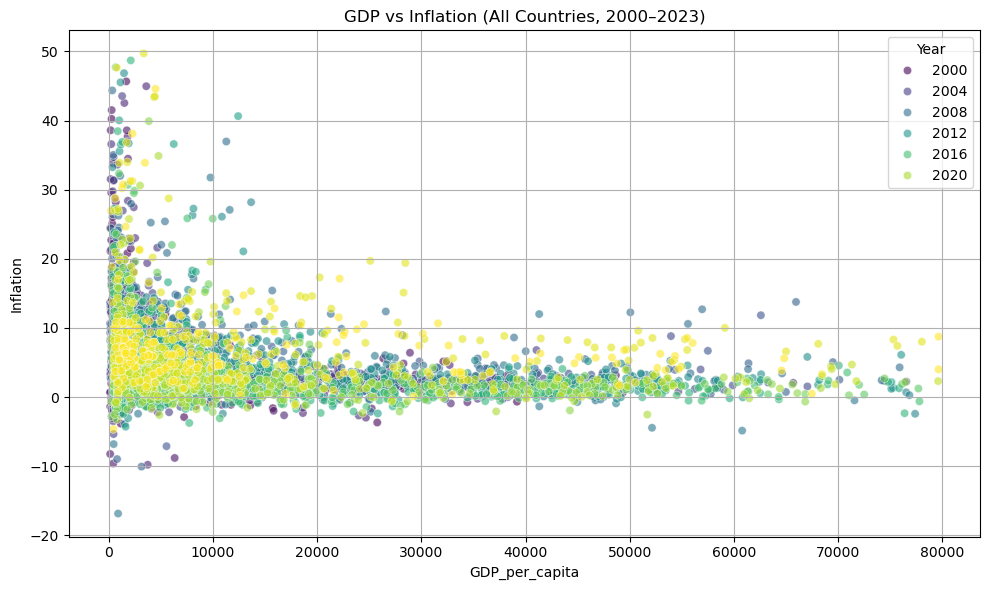

In [31]:
## Remove extreme outliers and NaNs
filtered = df.dropna()
filtered = filtered[(filtered["GDP_per_capita"] < 80000) & (filtered["Inflation"].between(-20, 50))]

plt.figure(figsize=(10,6))
sns.scatterplot(data=filtered, x="GDP_per_capita", y="Inflation", hue="Year", palette="viridis", alpha=0.6)
plt.title("GDP vs Inflation (All Countries, 2000–2023)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [32]:
from scipy.stats import spearmanr

subset = df[["GDP_per_capita", "Inflation"]].dropna()
corr, pval = spearmanr(subset["GDP_per_capita"], subset["Inflation"])
print(f"Spearman correlation: {corr:.2f}, p-value: {pval:.4f}")


Spearman correlation: -0.40, p-value: 0.0000


This scatter plot illustrates the global relationship between GDP per capita and inflation from 2000 to 2023. In general, countries with higher GDP tend to have lower inflation levels, indicating a moderate negative correlation.

A Spearman rank correlation test confirms this relationship with a coefficient of **–0.40 (p < 0.001)**, suggesting that the association is statistically significant, but not strongly linear.

Especially among low-GDP countries, inflation varies widely, which weakens the overall trend. Therefore, while a downward pattern exists, it should be interpreted as a **moderate and statistically significant** but not strong negative correlation.


## 3.2 World Map: GDP per Capita in 2023

In [33]:

import plotly.express as px
gdp_2023_map = df[(df["Year"] == 2023) & (~df["GDP_per_capita"].isna())]

fig = px.choropleth(
    gdp_2023_map,
    locations="Country Code",
    color="GDP_per_capita",
    hover_name="Country Name",
    color_continuous_scale="Blues",
    title="World GDP per Capita in 2023 (Current US$)"
)
fig.update_layout(geo=dict(showframe=False, projection_type='natural earth'))
fig.show()

## Note: This map is interactive. The image shown here is a static screenshot.
## To explore the zoomable and draggable version, please run the corresponding cell in the Notebook.


This choropleth map displays the global distribution of GDP per capita in 2023. Darker shades indicate higher income levels, while lighter areas represent lower-income countries.

Key patterns observed:
- High-income regions include North America (e.g., the US, Canada), Western Europe (e.g., Germany, UK), and East Asia (e.g., Singapore, South Korea).
- Low-income areas are concentrated in Sub-Saharan Africa, South Asia (e.g., India, Bangladesh), and parts of Latin America.
- A pronounced "North–South divide" highlights global economic disparities.



*Map note: The world map is generated using Plotly's built-in geographic base (based on the [Natural Earth](https://www.naturalearthdata.com/) dataset) and visualized with 2023 GDP per capita data from the World Bank. The map is for data visualization purposes only and does not imply any political stance.*


# 4. ASEAN country


## 4.1 **Line Chart**: *GDP per Capita* & *Inflation Rate*

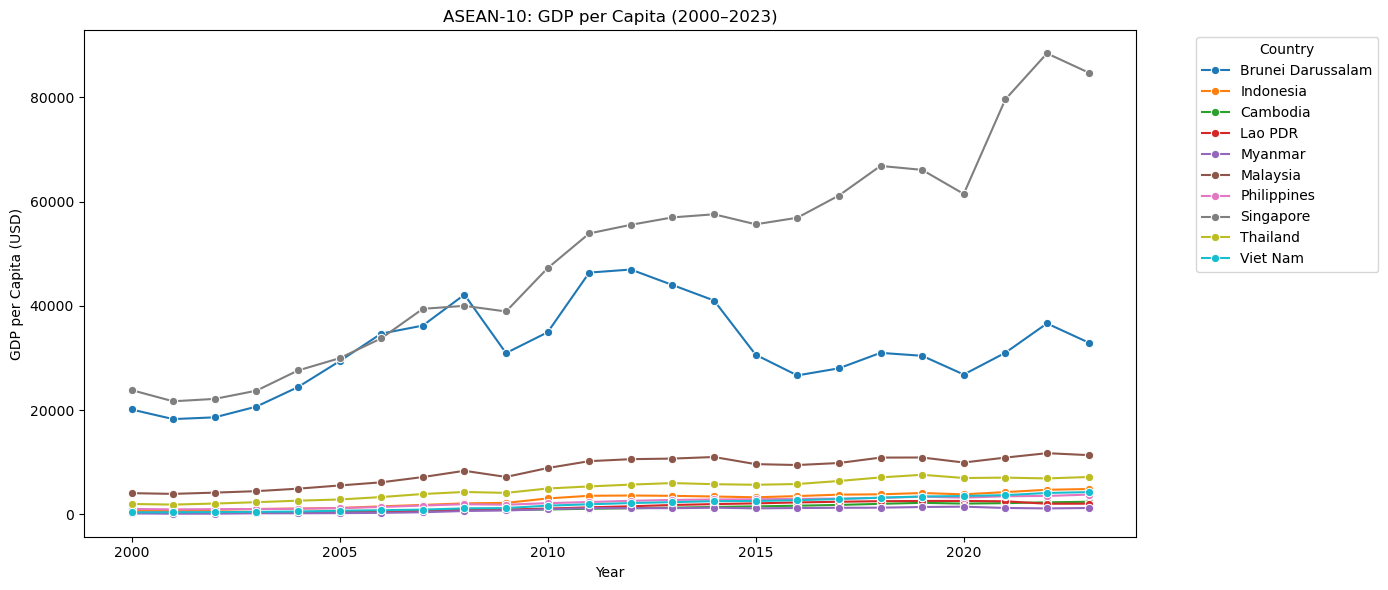

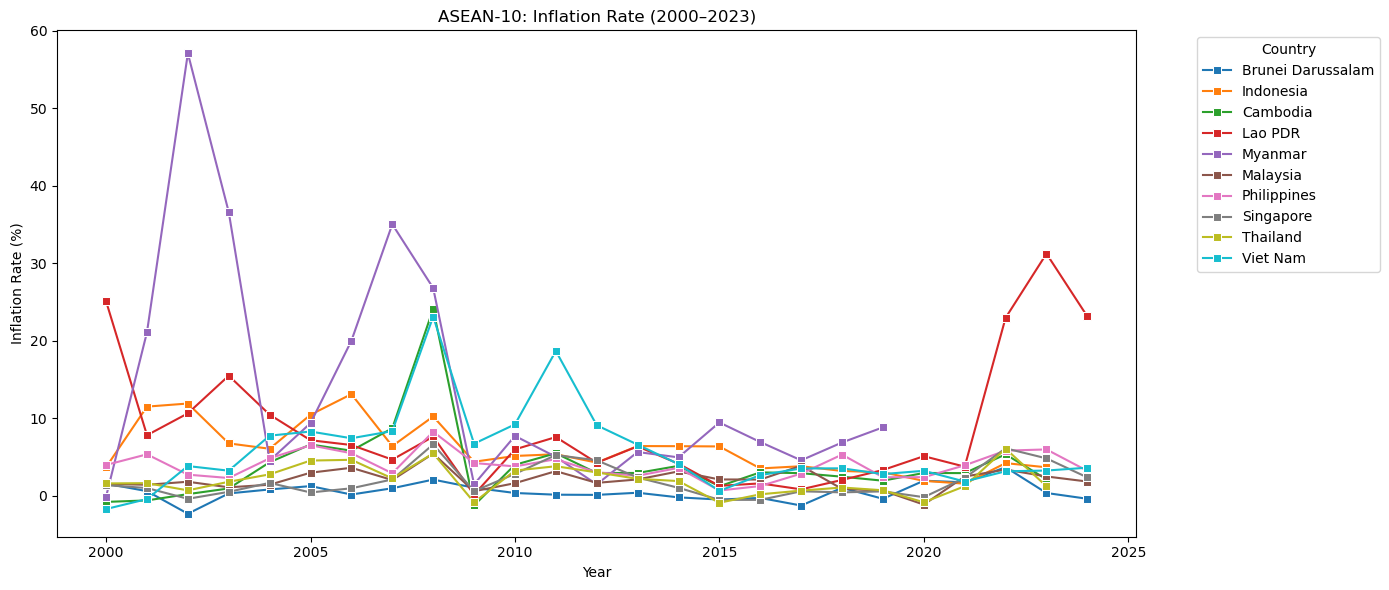

In [34]:

asean_countries = [
    "Malaysia", "Singapore", "Thailand", "Indonesia", "Philippines",
    "Viet Nam", "Brunei Darussalam", "Cambodia", "Lao PDR", "Myanmar"
]
asean_df = df[
    (df["Country Name"].isin(asean_countries))
]
# GDP per capita trend plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=asean_df, x="Year", y="GDP_per_capita", hue="Country Name", marker='o')
plt.title("ASEAN-10: GDP per Capita (2000–2023)")
plt.ylabel("GDP per Capita (USD)")
plt.xlabel("Year")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Inflation rate trend plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=asean_df, x="Year", y="Inflation", hue="Country Name", marker='s')
plt.title("ASEAN-10: Inflation Rate (2000–2023)")
plt.ylabel("Inflation Rate (%)")
plt.xlabel("Year")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 4.1.1 ASEAN-10 GDP per Capita

This chart tracks GDP per capita trends among ASEAN-10 countries from 2000 to 2023. Singapore and Brunei maintain top income positions with consistent growth.

Malaysia demonstrates stable mid-to-high income performance, while countries like Indonesia, Thailand, and the Philippines show gradual improvement.

Cambodia, Laos, and Myanmar remain in the lower-income category, though upward trends are visible.

Overall, the chart reveals significant economic stratification within the ASEAN region.


### 4.1.2 ASEAN-10 Inflation Rate

This line chart visualizes inflation rate trends among ASEAN-10 countries from 2000 to 2023. Considerable disparity exists in monetary stability across the region.

Countries like Singapore, Malaysia, and Thailand maintain consistently low inflation, suggesting strong policy frameworks.

Meanwhile, Myanmar, Laos, and Cambodia exhibit substantial volatility. Laos in particular shows inflation spikes above 30% in multiple years, often linked to political or economic crises.

The chart underscores differences in macroeconomic control among ASEAN nations.


## 4.2 **Heatmap**: *GDP* & *Inflation*

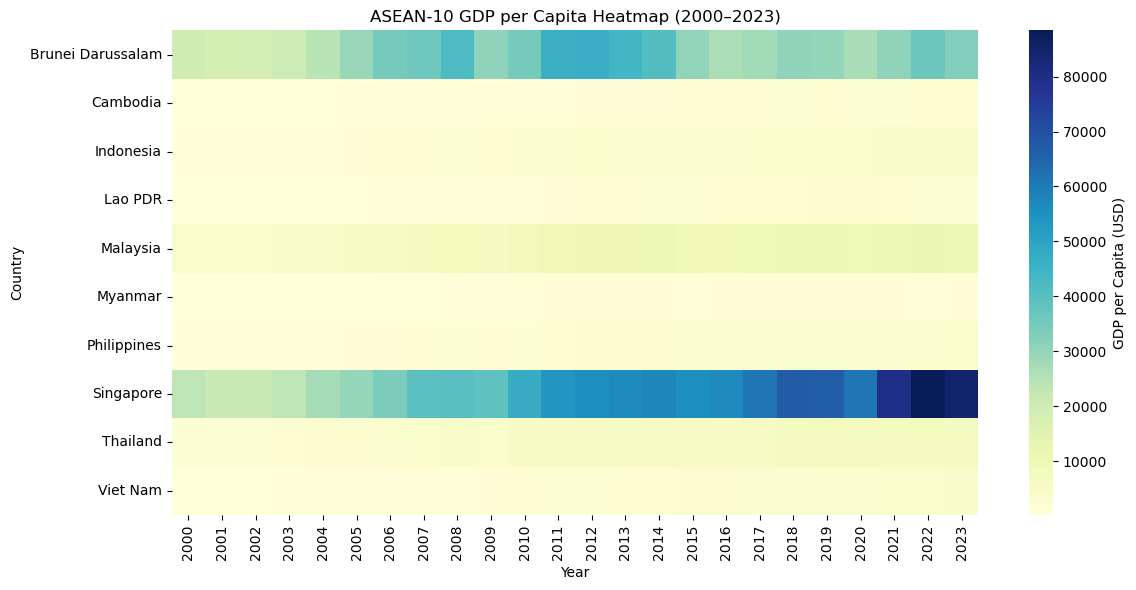

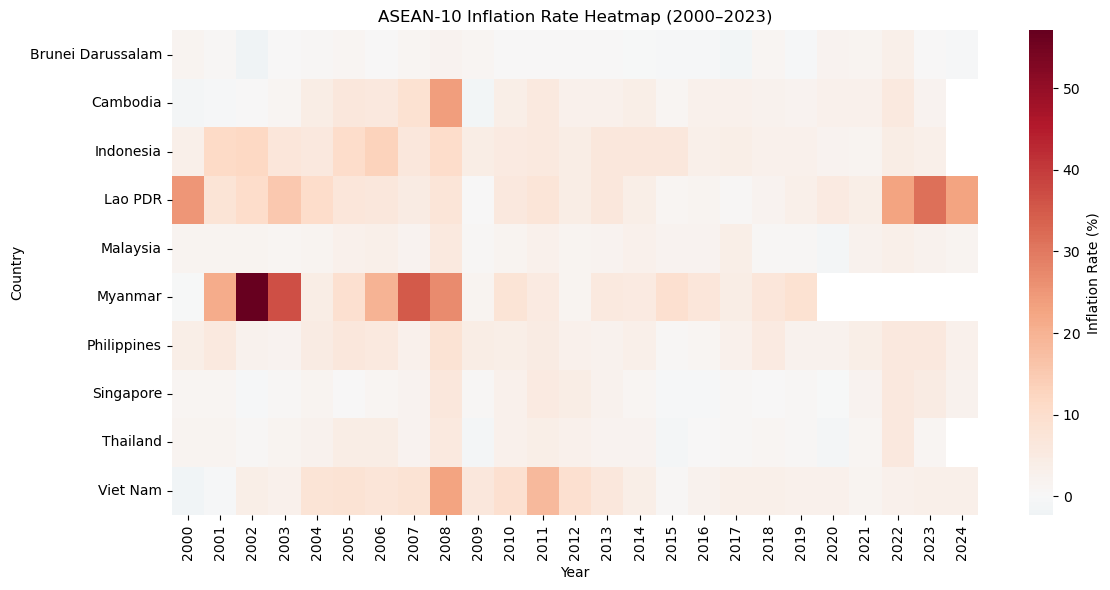

In [35]:

asean_gdp_pivot = asean_df.pivot_table(index="Country Name", columns="Year", values="GDP_per_capita")
asean_inflation_pivot = asean_df.pivot_table(index="Country Name", columns="Year", values="Inflation")

# Convert to float to avoid heatmap errors
asean_gdp_pivot = asean_gdp_pivot.astype(float)
asean_inflation_pivot = asean_inflation_pivot.astype(float)

# GDP Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(asean_gdp_pivot, cmap="YlGnBu", cbar_kws={"label": "GDP per Capita (USD)"})
plt.title("ASEAN-10 GDP per Capita Heatmap (2000–2023)")
plt.xlabel("Year")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Inflation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(asean_inflation_pivot, cmap="RdBu_r", center=0, cbar_kws={"label": "Inflation Rate (%)"})
plt.title("ASEAN-10 Inflation Rate Heatmap (2000–2023)")
plt.xlabel("Year")
plt.ylabel("Country")
plt.tight_layout()
plt.show()



This heatmap visualizes the evolution of GDP per capita among ASEAN countries from 2000 to 2023. Darker colors indicate higher income levels.

Key insights:
- Singapore and Brunei maintain high-income status throughout.
- Malaysia continues to maintain a medium-to-high income level and is showing an upward trend.
- Cambodia, Laos, and Myanmar remain in lower-income brackets.

It reflects the differences in economic strength among countries in the region and the asynchrony in their development paths.


This heatmap illustrates year-by-year inflation rate changes in ASEAN countries from 2000 to 2023. Darker shades reflect higher inflation levels.

Notable insights:
- Myanmar experienced significant inflation spikes in 2002, 2007, and 2022.
- Laos and Cambodia showed intermittent price instability.
- Malaysia, Singapore, and Thailand maintained low and steady inflation.
- Vietnam showed high inflation between 2008–2012 but improved stability afterward.

Reflects differences in regional monetary stability and economic policy implementation


##  4.3**Integrated Analysis: ASEAN-10 Economic Trends**

Combining the line charts and heatmaps, the ASEAN region shows clear economic stratification and varying levels of inflation control:

- GDP per capita levels form a three-tier pattern: high-income (Singapore, Brunei, Malaysia), mid-income (Thailand, Vietnam), and low-income (Cambodia, Laos, Myanmar).
- Vietnam shows strong income growth momentum, narrowing the gap with mid-tier countries.
- Inflation stability is highest in Singapore, Malaysia, and Thailand, while Myanmar and Laos display recurring spikes.
- Vietnam, despite earlier inflation volatility, has shown improved stability post-2013.

Overall, **Malaysia demonstrates a strong balance between economic growth and inflation control**, positioning itself as a regional policy model.


# 5. Malaysia Economic

##  5.1 Malaysia *GDP* vs *Inflation* (2000–2023)

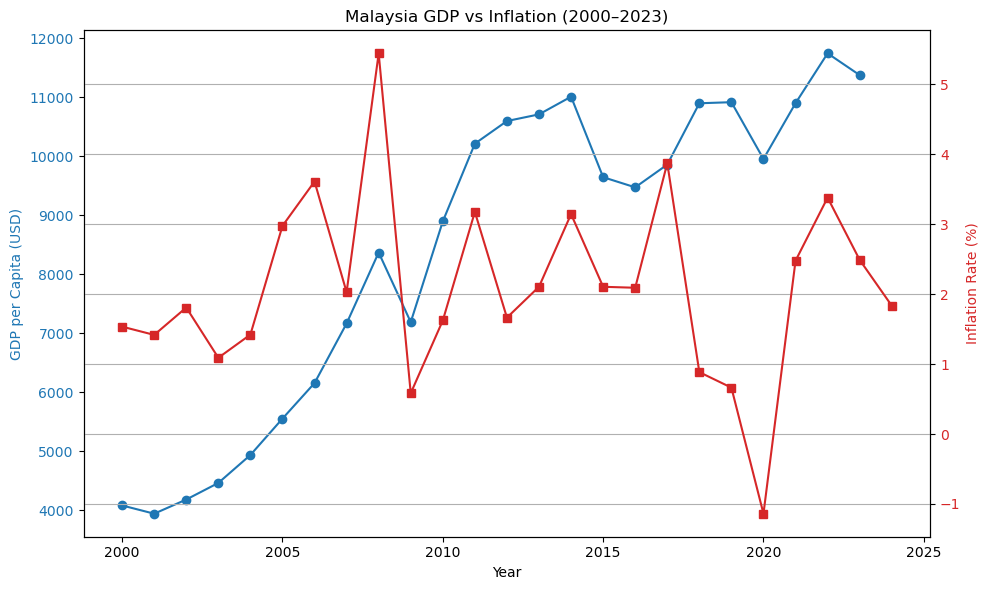

In [36]:

malaysia = df[df["Country Name"] == "Malaysia"]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel("Year")
ax1.set_ylabel("GDP per Capita (USD)", color='tab:blue')
ax1.plot(malaysia["Year"], malaysia["GDP_per_capita"], color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel("Inflation Rate (%)", color='tab:red')
ax2.plot(malaysia["Year"], malaysia["Inflation"], color='tab:red', marker='s')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title("Malaysia GDP vs Inflation (2000–2023)")
plt.tight_layout()
plt.grid(True)
plt.show()


This dual-axis chart compares Malaysia’s GDP per capita (left axis) and inflation rate (right axis) from 2000 to 2023.

Key observations:
- GDP per capita shows a consistent upward trend, especially between 2010 and 2019.
- Inflation remains within a low and stable range (0–4%), with mild deviations in crisis years.
- Notable synchronized dips appear in 2009 and 2020, aligning with the global financial crisis and COVID-19 pandemic.
- The chart illustrates Malaysia’s macroeconomic resilience and effective inflation control.

Overall, the chart reflects Malaysia’s middle-to-high-income status and macroeconomic stability in the region, and reflects the relatively mature regional governance structure.

## 5.2 Malaysia *Year-on-Year GDP per Capita Growth Rate (%)*

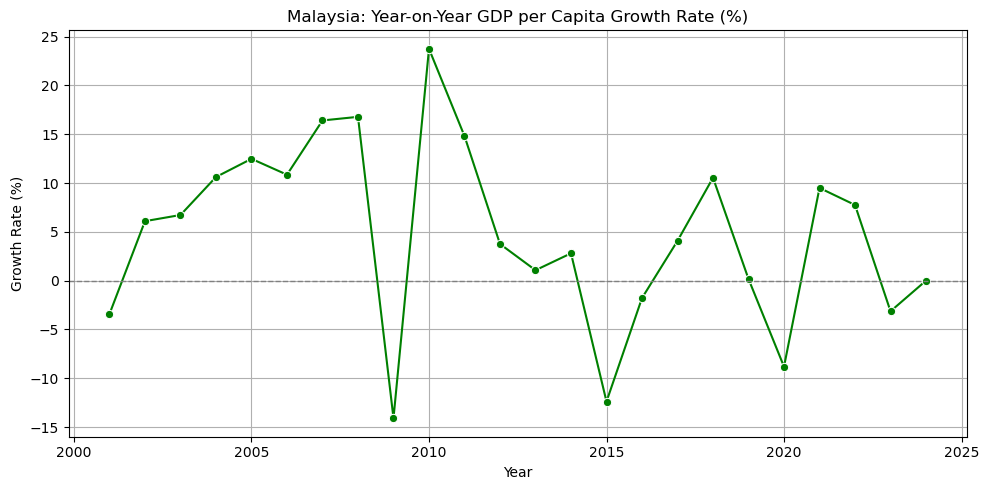

In [37]:
# Sort and calculate YoY GDP growth rate
malaysia_growth = df[df["Country Name"] == "Malaysia"].sort_values("Year").copy()
malaysia_growth["GDP_Growth_Rate"] = malaysia_growth["GDP_per_capita"].pct_change() * 100

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=malaysia_growth, x="Year", y="GDP_Growth_Rate", marker='o', color='green')
plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.title("Malaysia: Year-on-Year GDP per Capita Growth Rate (%)")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


This line chart shows Malaysia’s year-on-year growth in GDP per capita from 2000 to 2023.

Key insights:
- Most years exhibited robust growth between 5–15%, especially during 2002–2008 and 2017–2019.
- A sharp contraction of –13.6% in 2009 reflects the impact of the global financial crisis.
- The economy rebounded strongly with +24% growth in 2010.
- Additional downturns in 2015 (–13%) and 2020 (–9%) reflect the effects of the oil price crash and COVID-19 pandemic, respectively.
- Overall, Malaysia displays cyclical volatility but also strong post-crisis recovery momentum.

This highlights that Malaysia has a certain degree of economic sensitivity, but its policy response and structural recovery capabilities are relatively strong.

## 5.3 Malaysia: GDP vs Inflation Area Difference

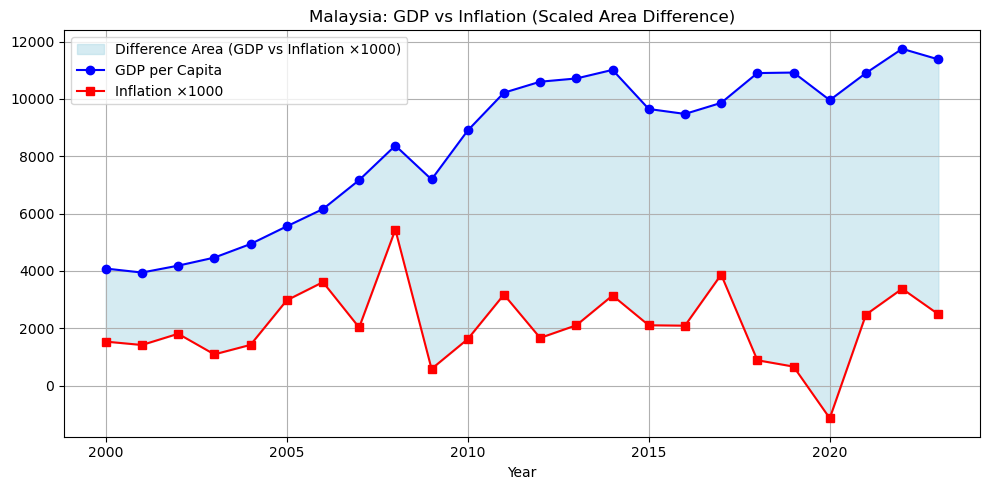

In [38]:
# Prepare data: drop missing, convert to float, scale inflation
malaysia_valid = df[df["Country Name"] == "Malaysia"][["Year", "GDP_per_capita", "Inflation"]].dropna()
malaysia_valid["GDP_per_capita"] = pd.to_numeric(malaysia_valid["GDP_per_capita"], errors="coerce")
malaysia_valid["Inflation"] = pd.to_numeric(malaysia_valid["Inflation"], errors="coerce")
malaysia_valid = malaysia_valid.dropna()

# Extract as numpy arrays for plotting
years = malaysia_valid["Year"].values.astype(float)
gdp = malaysia_valid["GDP_per_capita"].values.astype(float)
inflation_scaled = (malaysia_valid["Inflation"] * 1000).values.astype(float)

# Plot area difference
plt.figure(figsize=(10, 5))
plt.fill_between(years, gdp, inflation_scaled, color='lightblue', alpha=0.5,
                 label='Difference Area (GDP vs Inflation ×1000)')
plt.plot(years, gdp, label="GDP per Capita", color="blue", marker='o')
plt.plot(years, inflation_scaled, label="Inflation ×1000", color="red", marker='s')
plt.title("Malaysia: GDP vs Inflation (Scaled Area Difference)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This chart compares Malaysia’s GDP per capita and inflation from 2000 to 2023 using a filled area plot. Inflation is scaled by ×1000 to align with GDP’s magnitude.

Key insights include:
- A wide gap between GDP and inflation curves in most years reflects effective growth beyond price increases;
- The largest differences occur between 2013 and 2019, indicating strong net real growth;
- During 2009 and 2020, the area narrows as GDP slows and inflation spikes, showing external crisis impacts;
- In 2020, the inflation curve nearly touches or briefly overtakes GDP, signaling heightened pressure on real income.

Overall, Malaysia has maintained a favorable trend of "economic growth faster than inflation" in most years, reflecting its macro-control capabilities and growth quality.

## 5.4 Malaysia: Inflation Distribution by Decade

C:\Users\jdkjf\AppData\Local\Temp\ipykernel_7284\2165112184.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




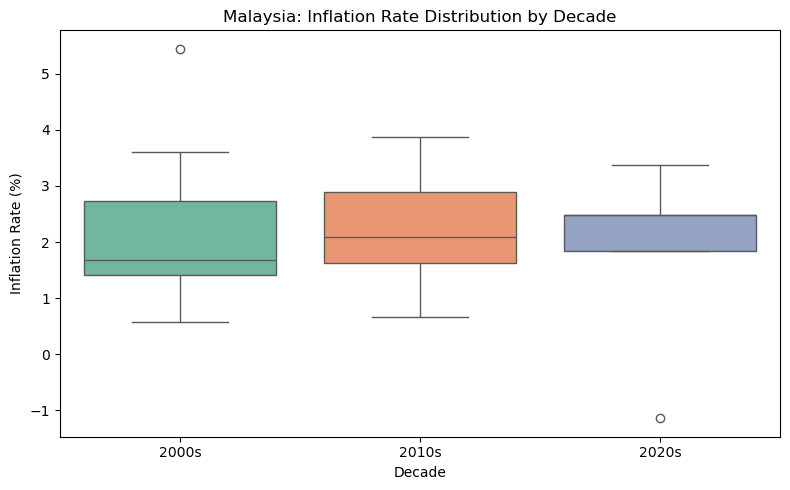

In [39]:
# Prepare decade grouping
malaysia = df[df["Country Name"] == "Malaysia"].copy()
malaysia["Decade"] = malaysia["Year"].apply(lambda y: f"{y//10*10}s")

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=malaysia, x="Decade", y="Inflation", palette="Set2")
plt.title("Malaysia: Inflation Rate Distribution by Decade")
plt.xlabel("Decade")
plt.ylabel("Inflation Rate (%)")
plt.tight_layout()
plt.show()


This boxplot illustrates inflation rate distribution in Malaysia across three decades: the 2000s, 2010s, and 2020s.

Key findings:

- **2000s**: Median inflation ≈1.6%, with wider variability and a high outlier (≈5.4%) corresponding to the 2008 global crisis;
- **2010s**: Median increased to ≈2.1%, with moderate spread and no extreme values;
- **2020s**: Median ≈2.6%, but the interquartile range is narrower, indicating reduced volatility. One low outlier (≈–1%) likely reflects the deflationary impact of COVID-19.


Overall, although the sample size in the 2020s is limited, the distribution of inflation rates during this period showed **strong concentration and low volatility**, reflecting the further maturity of Malaysia's inflation control mechanism in recent years.

# 6. Conclusion

This report, based on World Bank data, constructs a multi-level visualization analysis framework around two key indicators, namely GDP per capita and inflation rate, covering three perspectives: global, the ten ASEAN countries, and Malaysia.

At the **global level**, data shows a moderate negative correlation between GDP and inflation (Spearman ρ ≈ -0.40). Although inflation is generally low in high-income countries, the overall trend is pulled down by inflation fluctuations in low-income countries, failing to form a strong linear pattern. This indicates that the relationship between global economic development and price stability is complex and has regional characteristics.

At the **regional level**, the economic structures of the ten ASEAN countries are stratified into three tiers:
- Singapore and Brunei are in the high-income and high-stability category;
- Malaysia, Thailand, Indonesia, and others are in the middle-income and relatively stable inflation category;
- Myanmar, Laos, and other low-income countries have large inflation fluctuations and are significantly affected by external shocks.

**Malaysia**, as a mid-to-upper income ASEAN member, demonstrated:
- A generally steady growth in per capita GDP, with declines only during the global crises in 2009 and 2020;
- An inflation rate maintained within the range of 0 to 4%, with fluctuations continuously decreasing;
- Net growth where GDP growth outpaced inflation in most years;
- The inflation box plot shows that in the 2020s, the median was stable, fluctuations converged, and extreme values decreased, indicating significant effectiveness of macroeconomic policies.


#  7. Recommendations

- Malaysia should continue strengthening inflation control, especially during global crises, to preserve real income growth.
- ASEAN countries with higher inflation volatility (e.g., Myanmar, Laos) may benefit from targeted policy coordination or monetary reform.
- Long-term economic planning should consider not just GDP growth, but also inflation-adjusted living standards to ensure sustainable development.

